
# Maximal Representative Subsampling

### Table of contents

1. [Sampling Method](#sampling)
2. [Preprocessing](#prep)
    1. [GBS](#gbs)
    2. [Allensbach](#allensbach)
    3. [GESIS](#gesis)
3. [US National Census (Income)](#us)
    1. [Initial Classification](#sub1)
    2. [MRS](#sub2)
4. [Allensbach](#allensbach)

In [1]:
from pathlib import Path
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics
from scipy import stats

import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
import numpy as np
np.seterr(divide = 'ignore')

path = Path(os.getcwd()).parent

In [2]:
def sample(softmax, temperature):
    '''Temperature Sampling'''

    EPSILON = 10e-16 # to avoid taking the log of zero
    softmax = (np.array(softmax) + EPSILON).astype('float64')
    
    preds = np.log(softmax) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)

    return probas[0]

def remove(preds, max_drop, temperature):
    '''Removes instances based on temperature sampling'''
    
    to_drop = len(preds)*[0]
    for _ in range(max_drop):
        to_drop += (sample(preds, temperature))
        
    return to_drop

def plot_results(score):

    labels = [s[0] for s in score]
    preds = [s[1] for s in score]

    ks = [stats.ks_2samp(l, p) for l,p in zip(labels, preds)]
    auc = [metrics.roc_auc_score(l, p) for l,p in zip(labels, preds)]
    
    #plots([k[0] for k in ks], 'KS stats')
    #plots([k[1] for k in ks], 'KS P-value')
    plots(auc, 'AUC')

def plots(arr, stat):
    
    plt.plot(arr)
    if(stat == 'AUC'):
        plt.plot(len(arr)*[0.5])
    plt.xlabel("number of iterations")
    plt.ylabel(stat)
    plt.grid()
    plt.title('US National Cencus(Income)')


### US National Census (Income) <a name="us"></a>

*About this Dataset*

**US Adult Census** (1994) relates income to social factors: 

- *age*: continuous.
- *workclass*: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- *fnlwgt*: continuous.
- *education*: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- *education-num*: continuous.
- *marital-status*: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- *occupation*: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- *relationship*: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- *race*: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- *sex*: Female, Male.
- *capital-gain*: continuous.
- *capital-loss*: continuous.
- *hours-per-week*: continuous.
- *native-country*: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Each row is labelled as either having a salary greater than ">50K" or "<=50K".

Note: This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

In [3]:
columns = ['Age','Workclass','fnlgwt','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Above/Below 50K']

train = pd.read_csv(os.path.join(path, 'data/census_income/adult.data'), names=columns)
test = pd.read_csv(os.path.join(path, 'data/census_income/adult.test'), names=columns)
test = test.iloc[1:] # drop first row from test set

df = pd.concat([train, test]).copy(deep=True)

del train, test

df.replace(' >50K.', ' >50K', inplace=True)
df.replace(' <=50K.', ' <=50K', inplace=True)

df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

ctg = ['Workclass', 'Sex', 'Education', 'Marital Status', 
       'Occupation', 'Relationship', 'Race', 'Country'] # Categorical to Numerical

for c in ctg:
    df = pd.concat([df, pd.get_dummies(df[c], 
                                       prefix=c,
                                       dummy_na=False)], axis=1).drop([c],axis=1)

'''
Rep: 
<=50K    37155
>50K     11687
'''

df_high = df[df['Above/Below 50K'] == " >50K"].copy(deep=True)
df_low = df[df['Above/Below 50K'] == " <=50K"].copy(deep=True)

df_low = df_low.reindex(np.random.permutation(df_low.index))
df_high = df_high.reindex(np.random.permutation(df_high.index))

#rep = df.copy(deep=True)
rep = pd.concat([df_low.head(15890).copy(deep=True),
                 df_high.head(5000).copy(deep=True)], sort=True)

nonrep = pd.concat([df_low.tail(5000).copy(deep=True),
                    df_high.tail(6000).copy(deep=True)], sort=True)

print('Rep: \n', rep['Above/Below 50K'].value_counts(), '\n')
print('Nonrep: \n', nonrep['Above/Below 50K'].value_counts())

nonrep['label'] = 1
rep['label'] = 0

del df, df_low, df_high

data = pd.concat([nonrep, rep], sort=True)

cols = list(data.columns) 
meta = ['label', 'Above/Below 50K', 'index', 'bootstrap']
for m in meta:
    if m in cols:
        cols.remove(m)
        
data.head()

Rep: 
  <=50K    15890
 >50K      5000
Name: Above/Below 50K, dtype: int64 

Nonrep: 
  >50K     6000
 <=50K    5000
Name: Above/Below 50K, dtype: int64


Above/Below 50K Age  Capital Gain  Capital Loss  Country_ ?  \
27990           <=50K  40           0.0           0.0           0   
36367           <=50K  48           0.0           0.0           0   
40371           <=50K  47           0.0           0.0           0   
37631           <=50K  33           0.0           0.0           0   
2842            <=50K  28           0.0           0.0           0   

       Country_ Cambodia  Country_ Canada  Country_ China  Country_ Columbia  \
27990                  0                0               0                  0   
36367                  0                0               0                  0   
40371                  0                0               0                  0   
37631                  0                0               0                  0   
2842                   0                0               0                  0   

       Country_ Cuba  ...    Workclass_ Federal-gov  Workclass_ Local-gov  \
27990              0  ...                         0                     0   
36367              0  ...                         1                     0   
40371              0  ...                         0                     0   
37631              0  ...                         1                     0   
2842               0  ...                         0                     0   

       Workclass_ Never-worked  Workclass_ Private  Workclass_ Self-emp-inc  \
27990                        0                   1                        0   
36367                        0                   0                        0   
40371                        0                   1                        0   
37631                        0                   0                        0   
2842                         0                   1                        0   

       Workclass_ Self-emp-not-inc  Workclass_ State-gov  \
27990                            0                     0   
36367                            0                     0   
40371                            0                     0   
37631                            0                     0   
2842                             0                     0   

       Workclass_ Without-pay    fnlgwt  label  
27990                       0  434081.0      1  
36367                       0  265386.0      1  
40371                       0   44671.0      1  
37631                       0  198827.0      1  
2842                        0  109857.0      1  

[5 rows x 110 columns]

In [11]:
data[data['label']==0]['Above/Below 50K'].value_counts()

 <=50K    15890
 >50K      5000
Name: Above/Below 50K, dtype: int64

In [4]:
#data.to_csv('us_weka_out.csv', sep=',', index=False)
data_base = data.copy(deep=True)

31164, 30469, 29718, 28950, 28234, 27511, 26899, 26218, 25529, 24890, 24179, 23627, 23109, 22569, 21978, 21444, 20899, 20447, 19958, 19389, 19008, 18533, 18127, 17758, 17255, 30972, 30056, 29126, 28236, 27316, 26420, 25533, 24653, 23767, 22879, 21997, 21121, 20227, 19369, 18519, 17686, 16844, 16046, 30954, 30011, 29085, 28150, 27219, 26287, 25344, 24419, 23487, 22572, 21670, 20769, 19852, 18959, 18071, 17195, 16320, 15444, 30944, 30001, 29050, 28128, 27192, 26242, 25304, 24378, 23446, 22529, 21610, 20686, 19775, 18864, 17959, 17060, 16171, 15291, 

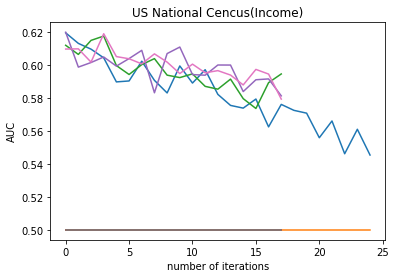

In [5]:
max_drop = 1000
limit = 5000
ensemble_size = 50

for t in np.arange(0.2, 1, 0.2):

    temperature = min(t, 1)
    score = []
    
    data = data_base.copy(deep=True)
    
    while (min(len(data[data.label == 1]), len(data[data.label == 0])) > limit and 
           len(data)>limit):    

        nonrep = data[data.label == 1].copy(deep=True)
        rep = data[data.label == 0].copy(deep=True)

        data = pd.concat([nonrep, rep], sort=True)
        
        train, test = train_test_split(data, test_size=0.33)
        bootstrap = pd.DataFrame(train).sample(len(train), replace=True)
        test = pd.DataFrame(test)

        preds = [0]*len(test)
        for _ in range(ensemble_size):
            
            dt = DecisionTreeClassifier(max_depth=5)
            dt.fit(bootstrap[cols], bootstrap.label)
            
            prob = [p[1] for p in dt.predict_proba(test[cols])]
            preds = [pre + pro for pre, pro in zip(preds, prob)]

        preds = [f/ensemble_size for f in preds]
        
        score.append((test.label, preds))

        test['removed'] = remove(preds, max_drop, temperature)
        test = test[test.removed == 0]
        test.drop('removed', axis=1)

        data = pd.concat([train, test], sort=True)

        print(len(data.index), end=', ')

    plot_results(score)
    
plt.show()